<a href="https://colab.research.google.com/github/satyajitghana/ProjektDepth/blob/master/notebooks/02_DepthModel_DepthMap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DenseDepth - Depth Map Creation

Make sure to get a Tesla P100 othewise you are doomed

In [0]:
! nvidia-smi

Tue May  5 15:51:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd gdrive/My\ Drive/DepthProject

/content/gdrive/My Drive/DepthProject


In [0]:
!ls -l

total 3159180
drwx------ 2 root root       4096 May  3 15:54 DenseDepth
drwx------ 2 root root       4096 May  3 22:30 depth_dataset_cleaned
-rw------- 1 root root    1706380 May  3 15:22 depth_dataset_cleaned_raw.zip
-rw------- 1 root root 2286492537 May  3 14:31 depth_dataset_cleaned.zip
drwx------ 2 root root       4096 May  4 11:36 depth_dataset_zipped
-rw------- 1 root root  946751654 May  4 22:51 depth_fg_bg.zip
drwx------ 2 root root       4096 May  4 15:02 temp_b
-rw------- 1 root root      10562 May  4 13:14 test2.png
-rw------- 1 root root      10530 May  4 13:15 test.png
-rw------- 1 root root      10654 May  4 13:30 zip_test.zip


## Download and Load the NYU Model

In [0]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5 -O DenseDepth/nyu.h5

--2020-05-04 11:53:26--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.97.51
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.97.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘DenseDepth/nyu.h5’

DenseDepth/nyu.h5   100%[===================>] 164.89M  62.8MB/s    in 2.6s    

2020-05-04 11:53:28 (62.8 MB/s) - ‘DenseDepth/nyu.h5’ saved [172897376/172897376]



In [0]:
ls DenseDepth

augment.py      demo_rgb.npy      LICENSE       PyTorch/     utils.py
callbacks.py    DenseDepth.ipynb  loss.py       README.md
data.py         evaluate.py       model.py      Tensorflow/
demo_depth.npy  examples/         nyu.h5        test.py
demo.py         layers.py         __pycache__/  train.py


In [0]:
import os
import glob
import argparse
import matplotlib

# Keras / TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'
from keras.models import load_model
from matplotlib import pyplot as plt
from DenseDepth.layers import BilinearUpSampling2D
from DenseDepth.utils import predict

MODEL_PATH = 'DenseDepth/nyu.h5'

# Custom object needed for inference and training
custom_objects = {'BilinearUpSampling2D': BilinearUpSampling2D, 'depth_loss_function': None}

print('Loading model...')

# Load model into GPU / CPU
model = load_model(MODEL_PATH, custom_objects=custom_objects, compile=False)

print('\nModel loaded ({0}).'.format(MODEL_PATH))

Using TensorFlow backend.


Loading model...

Model loaded (DenseDepth/nyu.h5).


In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [0]:
from zipfile import ZipFile
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import skimage
from skimage.transform import resize
from itertools import groupby
import cv2
from tqdm.auto import tqdm
from pathlib import Path
from time import time
import gc
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from functools import reduce
def make_batch(input_list, batch_size):
  def reducer(cumulator, item):
    if len(cumulator[-1]) < batch_size:
      cumulator[-1].append(item)
      return cumulator
    else:
      cumulator.append([item])
    return cumulator
  return reduce(reducer, input_list, [[]])

In [0]:
ls depth_dataset_zipped

fg_bg_mask.zip  fg_bg.zip  label_info.txt


In [0]:
fg_bg_zip =  ZipFile('depth_dataset_zipped/fg_bg.zip', 'r')

In [0]:
all_files = [info.filename for info in fg_bg_zip.infolist() if not info.is_dir()]

## Test if it works for 3 files

In [0]:
images = []
for file in all_files[:3]:
    imgdata = fg_bg_zip.read(file)
    img = Image.open(io.BytesIO(imgdata))
    img = img.resize((640, 480)) 
    x = np.clip(np.asarray(img, dtype=float) / 255, 0, 1)
    images.append(x)

In [0]:
images = np.stack(images, axis=0)

In [0]:
images.shape

(3, 480, 640, 3)

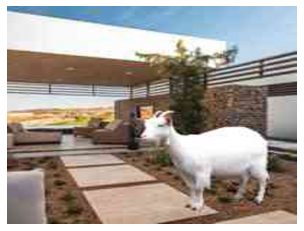

In [0]:
plt.imshow(images[0])
plt.grid('off')
plt.axis('off')
plt.show()

In [0]:
output = predict(model, images)

In [0]:
outputs, inputs = output.copy(), images.copy()

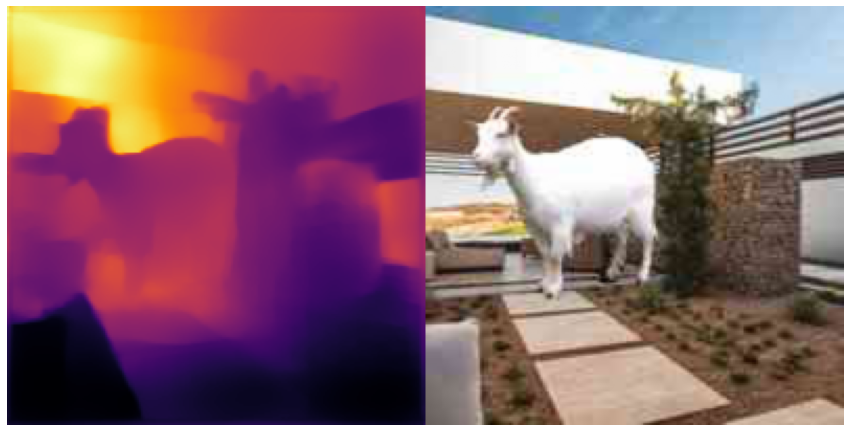

In [0]:
output, input = outputs[2], inputs[2]
output, input = resize(output, (200, 200)), resize(input, (200, 200))
plasma = plt.get_cmap('inferno')
rescaled = output[:,:,0]
rescaled = rescaled - np.min(rescaled)
rescaled = rescaled / np.max(rescaled)
out_img = plasma(rescaled)[:,:,:3]
img_set = np.hstack([out_img, input])
plt.figure(figsize=(15, 10))
plt.imshow(img_set)
plt.axis('off')
plt.grid('off')

In [0]:
meow = Image.fromarray(rescaled * 255)
meow = meow.convert('L')
byteIO = io.BytesIO()
meow.save(byteIO, format='PNG')
byteArr = byteIO.getvalue()

In [0]:
meow.save('test.png')

In [0]:
out_zip = ZipFile('zip_test.zip', mode='w', compression=zipfile.ZIP_STORED)

In [0]:
out_zip.write('test.png', arcname='meow/meow.png')

In [0]:
out_zip.close()

In [0]:
in_zip = ZipFile('zip_test.zip')

In [0]:
in_zip.infolist()

[<ZipInfo filename='meow/meow.png' filemode='-rw-------' file_size=10530>]

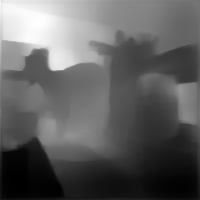

In [0]:
imgdata = in_zip.read('meow/meow.png')
img = Image.open(io.BytesIO(imgdata)).convert('L')
img

# Now Process all the Files

### **PROCEED WITH CAUTION**

In [0]:
!rm depth_fg_bg.zip

THIS PART IS SAFE

In [0]:
fg_bg_zip =  ZipFile('depth_dataset_zipped/fg_bg.zip', 'r')
all_files = [info.filename for info in fg_bg_zip.infolist() if not info.is_dir()]

In [0]:
all_files[0].split(os.sep)

['fg_bg', 'bg_000', 'fg_000_bg_000_000000.jpg']

In [0]:
grouped_files = [list(j) for i, j in groupby(all_files, lambda x: x.split(os.sep)[1])] 

In [0]:
len(grouped_files), len(grouped_files[55])

(100, 4000)

In [0]:
def run_processing(fr = 0, to = 10):
    print(f'running process from {fr}(inclusive) to {to}(exclusive) BGs')
    for bdx, b_files in enumerate( tqdm(grouped_files[fr:to]) ):

        print(f'Processing for BG {fr + bdx}')

        out_zip = ZipFile('depth_fg_bg.zip', mode='a', compression=zipfile.ZIP_STORED)

        batch_size = 1000
        batch_idx = 0
        for batch in make_batch(b_files, batch_size):
            images = []
            print(f'Processing Batch {batch_idx}')
            for idx, b_file in enumerate(tqdm(batch)):
                imgdata = fg_bg_zip.read(b_file)
                img = Image.open(io.BytesIO(imgdata))
                img = img.resize((640, 480)) 
                x = np.clip(np.asarray(img, dtype=float) / 255, 0, 1)
                images.append(x)

            images = np.stack(images, axis=0)
            print(f'Running prediction for BG {fr + bdx} Batch {batch_idx}')
            t1 = time()
            output = predict(model, images)
            outputs = output.copy()
            t2 = time()
            print(f'Prediction done took {(t2-t1):.5f} s')

            # resize the outputs to `200x200` and extract channel 0
            outputs = [ resize(output, (200, 200))[:, :, 0] for output in outputs]

            # create a temporary directory to save the png outputs of current bg directory
            Path(f'temp_b').mkdir(parents=True, exist_ok=True)

            print('Saving to Zip File')
            # for every output, save the output by appending mask to it
            for odx, output in enumerate(tqdm(outputs)):
                _, parent_f, f_name = b_files[ batch_idx*batch_size + odx].split(os.sep)
                f_name = f_name.split('.')[0]
                img = Image.fromarray(output * 255)
                img = img.convert('L')
                img.save(f'temp_b/temp.png')

                out_zip.write('temp_b/temp.png', f'depth_fg_bg/{parent_f}/mask_{f_name}.png')
            
            # cleanup files
            del output, outputs, images

            # garbage collect
            gc.collect()

            batch_idx = batch_idx + 1

        out_zip.close()

In [0]:
run_processing(fr = 0, to = 10)

running process from 0(inclusive) to 10(exclusive) BGs


Prcessing for BG 0
Processing Batch 0



Running prediction for BG 0 Batch 0
Prediction done took 62.60065 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 0 Batch 1
Prediction done took 62.47000 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 0 Batch 2
Prediction done took 62.39618 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 0 Batch 3
Prediction done took 62.35987 s
Saving to Zip File



Prcessing for BG 1
Processing Batch 0



Running prediction for BG 1 Batch 0
Prediction done took 62.47321 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 1 Batch 1
Prediction done took 62.71882 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 1 Batch 2
Prediction done took 62.45299 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 1 Batch 3
Prediction done took 62.64697 s
Saving to Zip File



Prcessing for BG 2
Processing Batch 0



Running prediction for BG 2 Batch 0
Prediction done took 62.56455 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 2 Batch 1
Prediction done took 62.64197 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 2 Batch 2
Prediction done took 62.63086 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 2 Batch 3
Prediction done took 62.50903 s
Saving to Zip File



Prcessing for BG 3
Processing Batch 0



Running prediction for BG 3 Batch 0
Prediction done took 62.59799 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 3 Batch 1
Prediction done took 62.58725 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 3 Batch 2
Prediction done took 62.48890 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 3 Batch 3
Prediction done took 62.62664 s
Saving to Zip File



Prcessing for BG 4
Processing Batch 0



Running prediction for BG 4 Batch 0
Prediction done took 62.75839 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 4 Batch 1
Prediction done took 62.66789 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 4 Batch 2
Prediction done took 62.50300 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 4 Batch 3
Prediction done took 62.58248 s
Saving to Zip File



Prcessing for BG 5
Processing Batch 0



Running prediction for BG 5 Batch 0
Prediction done took 62.50854 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 5 Batch 1
Prediction done took 62.63956 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 5 Batch 2
Prediction done took 62.65413 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 5 Batch 3
Prediction done took 62.63730 s
Saving to Zip File



Prcessing for BG 6
Processing Batch 0



Running prediction for BG 6 Batch 0
Prediction done took 62.55448 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 6 Batch 1
Prediction done took 62.70418 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 6 Batch 2
Prediction done took 62.71305 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 6 Batch 3
Prediction done took 62.55778 s
Saving to Zip File



Prcessing for BG 7
Processing Batch 0



Running prediction for BG 7 Batch 0
Prediction done took 62.52252 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 7 Batch 1
Prediction done took 62.62248 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 7 Batch 2
Prediction done took 62.46952 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 7 Batch 3
Prediction done took 62.44643 s
Saving to Zip File



Prcessing for BG 8
Processing Batch 0



Running prediction for BG 8 Batch 0
Prediction done took 62.65998 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 8 Batch 1
Prediction done took 62.52454 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 8 Batch 2
Prediction done took 62.38043 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 8 Batch 3
Prediction done took 62.44907 s
Saving to Zip File



Prcessing for BG 9
Processing Batch 0



Running prediction for BG 9 Batch 0
Prediction done took 62.56309 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 9 Batch 1
Prediction done took 62.51783 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 9 Batch 2
Prediction done took 62.38385 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 9 Batch 3
Prediction done took 62.61663 s
Saving to Zip File


In [0]:
run_processing(fr = 10, to = 20)

running process from 10(inclusive) to 20(exclusive) BGs


Prcessing for BG 0
Processing Batch 0



Running prediction for BG 0 Batch 0
Prediction done took 62.52364 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 0 Batch 1
Prediction done took 62.68566 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 0 Batch 2
Prediction done took 62.45280 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 0 Batch 3
Prediction done took 62.59288 s
Saving to Zip File



Prcessing for BG 1
Processing Batch 0



Running prediction for BG 1 Batch 0
Prediction done took 62.54203 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 1 Batch 1
Prediction done took 62.70778 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 1 Batch 2
Prediction done took 62.55583 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 1 Batch 3
Prediction done took 62.78586 s
Saving to Zip File



Prcessing for BG 2
Processing Batch 0



Running prediction for BG 2 Batch 0
Prediction done took 62.68907 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 2 Batch 1
Prediction done took 62.61751 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 2 Batch 2
Prediction done took 62.50362 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 2 Batch 3
Prediction done took 62.71632 s
Saving to Zip File



Prcessing for BG 3
Processing Batch 0



Running prediction for BG 3 Batch 0
Prediction done took 62.81059 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 3 Batch 1
Prediction done took 62.68132 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 3 Batch 2
Prediction done took 62.49175 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 3 Batch 3
Prediction done took 62.75343 s
Saving to Zip File



Prcessing for BG 4
Processing Batch 0



Running prediction for BG 4 Batch 0
Prediction done took 62.54260 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 4 Batch 1
Prediction done took 62.62111 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 4 Batch 2
Prediction done took 62.48096 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 4 Batch 3
Prediction done took 62.66178 s
Saving to Zip File



Prcessing for BG 5
Processing Batch 0



Running prediction for BG 5 Batch 0
Prediction done took 62.69331 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 5 Batch 1
Prediction done took 62.71588 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 5 Batch 2
Prediction done took 62.73884 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 5 Batch 3
Prediction done took 62.66852 s
Saving to Zip File



Prcessing for BG 6
Processing Batch 0



Running prediction for BG 6 Batch 0
Prediction done took 62.61214 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 6 Batch 1
Prediction done took 62.62599 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 6 Batch 2
Prediction done took 62.36841 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 6 Batch 3
Prediction done took 62.52908 s
Saving to Zip File



Prcessing for BG 7
Processing Batch 0



Running prediction for BG 7 Batch 0
Prediction done took 62.89403 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 7 Batch 1
Prediction done took 62.82999 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 7 Batch 2
Prediction done took 62.49039 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 7 Batch 3
Prediction done took 62.51443 s
Saving to Zip File



Prcessing for BG 8
Processing Batch 0



Running prediction for BG 8 Batch 0
Prediction done took 63.06712 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 8 Batch 1
Prediction done took 62.77366 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 8 Batch 2
Prediction done took 62.49818 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 8 Batch 3
Prediction done took 62.63990 s
Saving to Zip File



Prcessing for BG 9
Processing Batch 0



Running prediction for BG 9 Batch 0
Prediction done took 62.85587 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 9 Batch 1
Prediction done took 62.88064 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 9 Batch 2
Prediction done took 62.73234 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 9 Batch 3
Prediction done took 62.86150 s
Saving to Zip File


In [0]:
run_processing(fr = 20, to = 30)

running process from 20(inclusive) to 30(exclusive) BGs


Processing for BG 20
Processing Batch 0



Running prediction for BG 20 Batch 0
Prediction done took 63.04237 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 20 Batch 1
Prediction done took 62.94767 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 20 Batch 2
Prediction done took 63.02313 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 20 Batch 3
Prediction done took 62.74960 s
Saving to Zip File



Processing for BG 21
Processing Batch 0



Running prediction for BG 21 Batch 0
Prediction done took 63.40760 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 21 Batch 1
Prediction done took 62.89134 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 21 Batch 2
Prediction done took 62.65141 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 21 Batch 3
Prediction done took 62.76374 s
Saving to Zip File



Processing for BG 22
Processing Batch 0



Running prediction for BG 22 Batch 0
Prediction done took 62.73496 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 22 Batch 1
Prediction done took 62.82596 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 22 Batch 2
Prediction done took 62.70298 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 22 Batch 3
Prediction done took 62.75443 s
Saving to Zip File



Processing for BG 23
Processing Batch 0



Running prediction for BG 23 Batch 0
Prediction done took 63.22171 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 23 Batch 1
Prediction done took 63.02319 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 23 Batch 2
Prediction done took 62.70068 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 23 Batch 3
Prediction done took 62.77866 s
Saving to Zip File



Processing for BG 24
Processing Batch 0



Running prediction for BG 24 Batch 0
Prediction done took 63.30736 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 24 Batch 1
Prediction done took 63.41074 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 24 Batch 2
Prediction done took 62.95618 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 24 Batch 3
Prediction done took 62.89761 s
Saving to Zip File



Processing for BG 25
Processing Batch 0



Running prediction for BG 25 Batch 0
Prediction done took 63.05703 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 25 Batch 1
Prediction done took 63.24014 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 25 Batch 2
Prediction done took 62.78839 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 25 Batch 3
Prediction done took 62.97661 s
Saving to Zip File



Processing for BG 26
Processing Batch 0



Running prediction for BG 26 Batch 0
Prediction done took 63.08716 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 26 Batch 1
Prediction done took 62.83176 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 26 Batch 2
Prediction done took 62.57992 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 26 Batch 3
Prediction done took 62.69308 s
Saving to Zip File



Processing for BG 27
Processing Batch 0



Running prediction for BG 27 Batch 0
Prediction done took 62.96714 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 27 Batch 1
Prediction done took 62.94636 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 27 Batch 2
Prediction done took 62.63209 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 27 Batch 3
Prediction done took 62.76009 s
Saving to Zip File



Processing for BG 28
Processing Batch 0



Running prediction for BG 28 Batch 0
Prediction done took 63.12197 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 28 Batch 1
Prediction done took 63.18221 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 28 Batch 2
Prediction done took 62.93238 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 28 Batch 3
Prediction done took 62.93884 s
Saving to Zip File



Processing for BG 29
Processing Batch 0



Running prediction for BG 29 Batch 0
Prediction done took 62.99322 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 29 Batch 1
Prediction done took 62.72943 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 29 Batch 2
Prediction done took 62.78141 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 29 Batch 3
Prediction done took 62.81962 s
Saving to Zip File


In [0]:
run_processing(fr = 30, to = 60)

running process from 30(inclusive) to 60(exclusive) BGs


Processing for BG 30
Processing Batch 0



Running prediction for BG 30 Batch 0
Prediction done took 76.36149 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 30 Batch 1
Prediction done took 62.46233 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 30 Batch 2
Prediction done took 62.76149 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 30 Batch 3
Prediction done took 62.69183 s
Saving to Zip File



Processing for BG 31
Processing Batch 0



Running prediction for BG 31 Batch 0
Prediction done took 63.51704 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 31 Batch 1
Prediction done took 62.81795 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 31 Batch 2
Prediction done took 62.76241 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 31 Batch 3
Prediction done took 63.07431 s
Saving to Zip File



Processing for BG 32
Processing Batch 0



Running prediction for BG 32 Batch 0
Prediction done took 63.31818 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 32 Batch 1
Prediction done took 62.71128 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 32 Batch 2
Prediction done took 62.73443 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 32 Batch 3
Prediction done took 62.90790 s
Saving to Zip File



Processing for BG 33
Processing Batch 0



Running prediction for BG 33 Batch 0
Prediction done took 63.53429 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 33 Batch 1
Prediction done took 62.69091 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 33 Batch 2
Prediction done took 62.77197 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 33 Batch 3
Prediction done took 62.72512 s
Saving to Zip File



Processing for BG 34
Processing Batch 0



Running prediction for BG 34 Batch 0
Prediction done took 63.54705 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 34 Batch 1
Prediction done took 62.80411 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 34 Batch 2
Prediction done took 62.76597 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 34 Batch 3
Prediction done took 62.52587 s
Saving to Zip File



Processing for BG 35
Processing Batch 0



Running prediction for BG 35 Batch 0
Prediction done took 63.45154 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 35 Batch 1
Prediction done took 62.80261 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 35 Batch 2
Prediction done took 62.98806 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 35 Batch 3
Prediction done took 62.76968 s
Saving to Zip File



Processing for BG 36
Processing Batch 0



Running prediction for BG 36 Batch 0
Prediction done took 63.36008 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 36 Batch 1
Prediction done took 62.73491 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 36 Batch 2
Prediction done took 62.89488 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 36 Batch 3
Prediction done took 62.50520 s
Saving to Zip File



Processing for BG 37
Processing Batch 0



Running prediction for BG 37 Batch 0
Prediction done took 63.26441 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 37 Batch 1
Prediction done took 62.56216 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 37 Batch 2
Prediction done took 62.46236 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 37 Batch 3
Prediction done took 62.58522 s
Saving to Zip File



Processing for BG 38
Processing Batch 0



Running prediction for BG 38 Batch 0
Prediction done took 63.53198 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 38 Batch 1
Prediction done took 62.49045 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 38 Batch 2
Prediction done took 63.38498 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 38 Batch 3
Prediction done took 62.97490 s
Saving to Zip File



Processing for BG 39
Processing Batch 0



Running prediction for BG 39 Batch 0
Prediction done took 63.55654 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 39 Batch 1
Prediction done took 62.64126 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 39 Batch 2
Prediction done took 62.60886 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 39 Batch 3
Prediction done took 62.95253 s
Saving to Zip File



Processing for BG 40
Processing Batch 0



Running prediction for BG 40 Batch 0
Prediction done took 64.39813 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 40 Batch 1
Prediction done took 62.75056 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 40 Batch 2
Prediction done took 63.25474 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 40 Batch 3
Prediction done took 62.75029 s
Saving to Zip File



Processing for BG 41
Processing Batch 0



Running prediction for BG 41 Batch 0
Prediction done took 63.60848 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 41 Batch 1
Prediction done took 63.11298 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 41 Batch 2
Prediction done took 62.79398 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 41 Batch 3
Prediction done took 62.56143 s
Saving to Zip File



Processing for BG 42
Processing Batch 0



Running prediction for BG 42 Batch 0
Prediction done took 64.29783 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 42 Batch 1
Prediction done took 62.62884 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 42 Batch 2
Prediction done took 62.78540 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 42 Batch 3
Prediction done took 62.63022 s
Saving to Zip File



Processing for BG 43
Processing Batch 0



Running prediction for BG 43 Batch 0
Prediction done took 63.43088 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 43 Batch 1
Prediction done took 62.95672 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 43 Batch 2
Prediction done took 62.76128 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 43 Batch 3
Prediction done took 62.64819 s
Saving to Zip File



Processing for BG 44
Processing Batch 0



Running prediction for BG 44 Batch 0
Prediction done took 63.66122 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 44 Batch 1
Prediction done took 62.67623 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 44 Batch 2
Prediction done took 62.65413 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 44 Batch 3
Prediction done took 62.84152 s
Saving to Zip File



Processing for BG 45
Processing Batch 0



Running prediction for BG 45 Batch 0
Prediction done took 63.61503 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 45 Batch 1
Prediction done took 62.62922 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 45 Batch 2
Prediction done took 62.71044 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 45 Batch 3
Prediction done took 62.69649 s
Saving to Zip File



Processing for BG 46
Processing Batch 0



Running prediction for BG 46 Batch 0
Prediction done took 63.54363 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 46 Batch 1
Prediction done took 62.66795 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 46 Batch 2
Prediction done took 62.53650 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 46 Batch 3
Prediction done took 62.56027 s
Saving to Zip File



Processing for BG 47
Processing Batch 0



Running prediction for BG 47 Batch 0
Prediction done took 63.33752 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 47 Batch 1
Prediction done took 62.92794 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 47 Batch 2
Prediction done took 63.17668 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 47 Batch 3
Prediction done took 62.85124 s
Saving to Zip File



Processing for BG 48
Processing Batch 0



Running prediction for BG 48 Batch 0
Prediction done took 63.88328 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 48 Batch 1
Prediction done took 62.97220 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 48 Batch 2
Prediction done took 62.92530 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 48 Batch 3
Prediction done took 62.85375 s
Saving to Zip File



Processing for BG 49
Processing Batch 0



Running prediction for BG 49 Batch 0
Prediction done took 63.76197 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 49 Batch 1
Prediction done took 62.73307 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 49 Batch 2
Prediction done took 62.68851 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 49 Batch 3
Prediction done took 62.56193 s
Saving to Zip File



Processing for BG 50
Processing Batch 0



Running prediction for BG 50 Batch 0
Prediction done took 63.57541 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 50 Batch 1
Prediction done took 62.79499 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 50 Batch 2
Prediction done took 62.73215 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 50 Batch 3
Prediction done took 62.98540 s
Saving to Zip File



Processing for BG 51
Processing Batch 0



Running prediction for BG 51 Batch 0
Prediction done took 63.62948 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 51 Batch 1
Prediction done took 62.91584 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 51 Batch 2
Prediction done took 62.80753 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 51 Batch 3
Prediction done took 62.69047 s
Saving to Zip File



Processing for BG 52
Processing Batch 0



Running prediction for BG 52 Batch 0
Prediction done took 62.99668 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 52 Batch 1
Prediction done took 62.65497 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 52 Batch 2
Prediction done took 62.61946 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 52 Batch 3
Prediction done took 62.57201 s
Saving to Zip File



Processing for BG 53
Processing Batch 0



Running prediction for BG 53 Batch 0
Prediction done took 63.58013 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 53 Batch 1
Prediction done took 62.79652 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 53 Batch 2
Prediction done took 62.80764 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 53 Batch 3
Prediction done took 62.46192 s
Saving to Zip File



Processing for BG 54
Processing Batch 0



Running prediction for BG 54 Batch 0
Prediction done took 63.82634 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 54 Batch 1
Prediction done took 62.84387 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 54 Batch 2
Prediction done took 62.69760 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 54 Batch 3
Prediction done took 62.72980 s
Saving to Zip File



Processing for BG 55
Processing Batch 0



Running prediction for BG 55 Batch 0
Prediction done took 64.23204 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 55 Batch 1
Prediction done took 62.86051 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 55 Batch 2
Prediction done took 62.74568 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 55 Batch 3
Prediction done took 62.30896 s
Saving to Zip File



Processing for BG 56
Processing Batch 0



Running prediction for BG 56 Batch 0
Prediction done took 64.05405 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 56 Batch 1
Prediction done took 62.58245 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 56 Batch 2
Prediction done took 62.70285 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 56 Batch 3
Prediction done took 62.95341 s
Saving to Zip File



Processing for BG 57
Processing Batch 0



Running prediction for BG 57 Batch 0
Prediction done took 63.84214 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 57 Batch 1
Prediction done took 62.75835 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 57 Batch 2
Prediction done took 62.78560 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 57 Batch 3
Prediction done took 62.84679 s
Saving to Zip File



Processing for BG 58
Processing Batch 0



Running prediction for BG 58 Batch 0
Prediction done took 63.34541 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 58 Batch 1
Prediction done took 62.73462 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 58 Batch 2
Prediction done took 62.75348 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 58 Batch 3
Prediction done took 62.62680 s
Saving to Zip File



Processing for BG 59
Processing Batch 0



Running prediction for BG 59 Batch 0
Prediction done took 63.60860 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 59 Batch 1
Prediction done took 62.87157 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 59 Batch 2
Prediction done took 62.93727 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 59 Batch 3
Prediction done took 62.73766 s
Saving to Zip File


In [0]:
run_processing(fr = 60, to = 100)

running process from 60(inclusive) to 100(exclusive) BGs


Processing for BG 60
Processing Batch 0



Running prediction for BG 60 Batch 0
Prediction done took 63.14717 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 60 Batch 1
Prediction done took 63.06059 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 60 Batch 2
Prediction done took 63.07934 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 60 Batch 3
Prediction done took 63.09197 s
Saving to Zip File



Processing for BG 61
Processing Batch 0



Running prediction for BG 61 Batch 0
Prediction done took 63.71033 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 61 Batch 1
Prediction done took 62.83444 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 61 Batch 2
Prediction done took 62.73028 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 61 Batch 3
Prediction done took 62.39805 s
Saving to Zip File



Processing for BG 62
Processing Batch 0



Running prediction for BG 62 Batch 0
Prediction done took 63.43232 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 62 Batch 1
Prediction done took 62.79581 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 62 Batch 2
Prediction done took 62.71061 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 62 Batch 3
Prediction done took 62.68314 s
Saving to Zip File



Processing for BG 63
Processing Batch 0



Running prediction for BG 63 Batch 0
Prediction done took 63.70987 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 63 Batch 1
Prediction done took 62.84699 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 63 Batch 2
Prediction done took 62.81573 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 63 Batch 3
Prediction done took 62.77689 s
Saving to Zip File



Processing for BG 64
Processing Batch 0



Running prediction for BG 64 Batch 0
Prediction done took 64.30613 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 64 Batch 1
Prediction done took 62.79283 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 64 Batch 2
Prediction done took 62.75061 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 64 Batch 3
Prediction done took 62.75312 s
Saving to Zip File



Processing for BG 65
Processing Batch 0



Running prediction for BG 65 Batch 0
Prediction done took 64.03252 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 65 Batch 1
Prediction done took 62.90617 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 65 Batch 2
Prediction done took 62.73302 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 65 Batch 3
Prediction done took 62.85382 s
Saving to Zip File



Processing for BG 66
Processing Batch 0



Running prediction for BG 66 Batch 0
Prediction done took 64.53136 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 66 Batch 1
Prediction done took 62.90571 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 66 Batch 2
Prediction done took 62.82413 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 66 Batch 3
Prediction done took 62.83099 s
Saving to Zip File



Processing for BG 67
Processing Batch 0



Running prediction for BG 67 Batch 0
Prediction done took 64.45781 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 67 Batch 1
Prediction done took 62.98454 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 67 Batch 2
Prediction done took 62.96482 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 67 Batch 3
Prediction done took 63.06213 s
Saving to Zip File



Processing for BG 68
Processing Batch 0



Running prediction for BG 68 Batch 0
Prediction done took 64.35568 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 68 Batch 1
Prediction done took 62.96986 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 68 Batch 2
Prediction done took 62.98201 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 68 Batch 3
Prediction done took 62.95681 s
Saving to Zip File



Processing for BG 69
Processing Batch 0



Running prediction for BG 69 Batch 0
Prediction done took 63.88452 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 69 Batch 1
Prediction done took 62.88204 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 69 Batch 2
Prediction done took 62.96034 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 69 Batch 3
Prediction done took 62.87257 s
Saving to Zip File



Processing for BG 70
Processing Batch 0



Running prediction for BG 70 Batch 0
Prediction done took 64.26763 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 70 Batch 1
Prediction done took 63.20985 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 70 Batch 2
Prediction done took 63.15001 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 70 Batch 3
Prediction done took 63.07256 s
Saving to Zip File



Processing for BG 71
Processing Batch 0



Running prediction for BG 71 Batch 0
Prediction done took 64.38795 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 71 Batch 1
Prediction done took 63.04799 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 71 Batch 2
Prediction done took 63.04689 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 71 Batch 3
Prediction done took 62.91537 s
Saving to Zip File



Processing for BG 72
Processing Batch 0



Running prediction for BG 72 Batch 0
Prediction done took 64.05800 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 72 Batch 1
Prediction done took 62.79802 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 72 Batch 2
Prediction done took 62.75837 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 72 Batch 3
Prediction done took 62.80056 s
Saving to Zip File



Processing for BG 73
Processing Batch 0



Running prediction for BG 73 Batch 0
Prediction done took 64.55373 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 73 Batch 1
Prediction done took 62.87995 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 73 Batch 2
Prediction done took 62.76363 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 73 Batch 3
Prediction done took 62.93719 s
Saving to Zip File



Processing for BG 74
Processing Batch 0



Running prediction for BG 74 Batch 0
Prediction done took 64.13950 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 74 Batch 1
Prediction done took 63.04079 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 74 Batch 2
Prediction done took 63.02640 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 74 Batch 3
Prediction done took 62.93577 s
Saving to Zip File



Processing for BG 75
Processing Batch 0



Running prediction for BG 75 Batch 0
Prediction done took 63.84358 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 75 Batch 1
Prediction done took 63.20842 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 75 Batch 2
Prediction done took 63.24997 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 75 Batch 3
Prediction done took 62.73474 s
Saving to Zip File



Processing for BG 76
Processing Batch 0



Running prediction for BG 76 Batch 0
Prediction done took 63.85799 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 76 Batch 1
Prediction done took 62.89134 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 76 Batch 2
Prediction done took 62.86622 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 76 Batch 3
Prediction done took 62.82576 s
Saving to Zip File



Processing for BG 77
Processing Batch 0



Running prediction for BG 77 Batch 0
Prediction done took 64.06231 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 77 Batch 1
Prediction done took 62.95312 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 77 Batch 2
Prediction done took 62.91370 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 77 Batch 3
Prediction done took 62.87919 s
Saving to Zip File



Processing for BG 78
Processing Batch 0



Running prediction for BG 78 Batch 0
Prediction done took 64.81658 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 78 Batch 1
Prediction done took 63.05571 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 78 Batch 2
Prediction done took 63.04941 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 78 Batch 3
Prediction done took 63.10328 s
Saving to Zip File



Processing for BG 79
Processing Batch 0



Running prediction for BG 79 Batch 0
Prediction done took 64.56934 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 79 Batch 1
Prediction done took 62.87712 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 79 Batch 2
Prediction done took 62.88766 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 79 Batch 3
Prediction done took 62.61322 s
Saving to Zip File



Processing for BG 80
Processing Batch 0



Running prediction for BG 80 Batch 0
Prediction done took 63.68563 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 80 Batch 1
Prediction done took 62.74288 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 80 Batch 2
Prediction done took 62.85226 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 80 Batch 3
Prediction done took 62.83587 s
Saving to Zip File



Processing for BG 81
Processing Batch 0



Running prediction for BG 81 Batch 0
Prediction done took 63.80363 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 81 Batch 1
Prediction done took 62.85890 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 81 Batch 2
Prediction done took 62.81901 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 81 Batch 3
Prediction done took 62.79822 s
Saving to Zip File



Processing for BG 82
Processing Batch 0



Running prediction for BG 82 Batch 0
Prediction done took 64.21405 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 82 Batch 1
Prediction done took 63.09478 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 82 Batch 2
Prediction done took 63.04221 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 82 Batch 3
Prediction done took 63.01039 s
Saving to Zip File



Processing for BG 83
Processing Batch 0



Running prediction for BG 83 Batch 0
Prediction done took 64.05712 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 83 Batch 1
Prediction done took 62.91903 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 83 Batch 2
Prediction done took 63.11112 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 83 Batch 3
Prediction done took 63.07499 s
Saving to Zip File



Processing for BG 84
Processing Batch 0



Running prediction for BG 84 Batch 0
Prediction done took 65.31120 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 84 Batch 1
Prediction done took 62.60474 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 84 Batch 2
Prediction done took 62.67011 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 84 Batch 3
Prediction done took 62.69721 s
Saving to Zip File



Processing for BG 85
Processing Batch 0



Running prediction for BG 85 Batch 0
Prediction done took 63.79561 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 85 Batch 1
Prediction done took 62.67840 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 85 Batch 2
Prediction done took 62.68801 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 85 Batch 3
Prediction done took 62.78947 s
Saving to Zip File



Processing for BG 86
Processing Batch 0



Running prediction for BG 86 Batch 0
Prediction done took 64.93838 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 86 Batch 1
Prediction done took 62.80661 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 86 Batch 2
Prediction done took 62.97924 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 86 Batch 3
Prediction done took 62.92368 s
Saving to Zip File



Processing for BG 87
Processing Batch 0



Running prediction for BG 87 Batch 0
Prediction done took 63.84746 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 87 Batch 1
Prediction done took 62.64802 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 87 Batch 2
Prediction done took 62.81550 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 87 Batch 3
Prediction done took 62.63340 s
Saving to Zip File



Processing for BG 88
Processing Batch 0



Running prediction for BG 88 Batch 0
Prediction done took 63.65625 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 88 Batch 1
Prediction done took 62.74304 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 88 Batch 2
Prediction done took 63.10574 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 88 Batch 3
Prediction done took 63.21715 s
Saving to Zip File



Processing for BG 89
Processing Batch 0



Running prediction for BG 89 Batch 0
Prediction done took 64.06693 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 89 Batch 1
Prediction done took 63.00363 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 89 Batch 2
Prediction done took 62.89306 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 89 Batch 3
Prediction done took 62.84085 s
Saving to Zip File



Processing for BG 90
Processing Batch 0



Running prediction for BG 90 Batch 0
Prediction done took 64.63945 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 90 Batch 1
Prediction done took 62.90799 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 90 Batch 2
Prediction done took 62.87425 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 90 Batch 3
Prediction done took 62.92446 s
Saving to Zip File



Processing for BG 91
Processing Batch 0



Running prediction for BG 91 Batch 0
Prediction done took 65.15176 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 91 Batch 1
Prediction done took 63.18536 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 91 Batch 2
Prediction done took 63.21471 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 91 Batch 3
Prediction done took 62.95613 s
Saving to Zip File



Processing for BG 92
Processing Batch 0



Running prediction for BG 92 Batch 0
Prediction done took 64.12670 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 92 Batch 1
Prediction done took 62.97107 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 92 Batch 2
Prediction done took 63.09376 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 92 Batch 3
Prediction done took 62.95032 s
Saving to Zip File



Processing for BG 93
Processing Batch 0



Running prediction for BG 93 Batch 0
Prediction done took 65.17238 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 93 Batch 1
Prediction done took 63.03480 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 93 Batch 2
Prediction done took 62.99073 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 93 Batch 3
Prediction done took 62.82586 s
Saving to Zip File



Processing for BG 94
Processing Batch 0



Running prediction for BG 94 Batch 0
Prediction done took 64.10651 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 94 Batch 1
Prediction done took 62.65821 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 94 Batch 2
Prediction done took 62.64198 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 94 Batch 3
Prediction done took 62.60398 s
Saving to Zip File



Processing for BG 95
Processing Batch 0



Running prediction for BG 95 Batch 0
Prediction done took 65.06775 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 95 Batch 1
Prediction done took 62.92917 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 95 Batch 2
Prediction done took 62.88929 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 95 Batch 3
Prediction done took 62.96181 s
Saving to Zip File



Processing for BG 96
Processing Batch 0



Running prediction for BG 96 Batch 0
Prediction done took 64.15451 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 96 Batch 1
Prediction done took 62.79361 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 96 Batch 2
Prediction done took 62.83280 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 96 Batch 3
Prediction done took 62.93230 s
Saving to Zip File



Processing for BG 97
Processing Batch 0



Running prediction for BG 97 Batch 0
Prediction done took 64.83054 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 97 Batch 1
Prediction done took 62.87158 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 97 Batch 2
Prediction done took 63.39410 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 97 Batch 3
Prediction done took 63.29049 s
Saving to Zip File



Processing for BG 98
Processing Batch 0



Running prediction for BG 98 Batch 0
Prediction done took 64.29691 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 98 Batch 1
Prediction done took 63.03310 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 98 Batch 2
Prediction done took 63.28047 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 98 Batch 3
Prediction done took 63.11109 s
Saving to Zip File



Processing for BG 99
Processing Batch 0



Running prediction for BG 99 Batch 0
Prediction done took 64.30097 s
Saving to Zip File



Processing Batch 1



Running prediction for BG 99 Batch 1
Prediction done took 62.85119 s
Saving to Zip File



Processing Batch 2



Running prediction for BG 99 Batch 2
Prediction done took 62.78905 s
Saving to Zip File



Processing Batch 3



Running prediction for BG 99 Batch 3
Prediction done took 62.97428 s
Saving to Zip File
